# Setup

## Installs

In [1]:
# Segmentation
# ! pip install --upgrade mxnet
# ! pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
# ! pip install --upgrade gluoncv

# Edge detection
# ! conda install scikit-image

# Depth estimation
# ! pip install -q transformers

## Imports

In [2]:
import numpy as np
import cv2
from os import listdir

In [3]:
# Import custom methods
import general_methods
import semantic_segmentation
import edge_detection
import depth_estimation
import geometry
import transforms

c:\Users\Kim\anaconda3\envs\pipeline1\lib\site-packages\gluoncv\__init__.py:40: UserWarning: Both `mxnet==1.7.0` and `torch==1.6.0+cpu` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [4]:
# Get pre-trained models
seg_model = semantic_segmentation.get_pretrained_model()

In [5]:
def pipeline(filename):
    input_pil = general_methods.import_and_resize(filename)
    input_img = general_methods.import_mx_image(filename)

    # Segmentation
    mmask = semantic_segmentation.get_segementation(input_img, seg_model)
    labels = general_methods.get_labels_string(mmask)
    walls = general_methods.find_wall_indices(labels)
    other = general_methods.find_non_wall_indices(labels)
    segmented_input = semantic_segmentation.remove_walls(input_img, other)

    # Depth estimation
    depth_image = depth_estimation.estimate_depth(input_pil)

    # Edge detection
    input_cv2 = general_methods.import_cv2_image(filename)
    edge_map = edge_detection.detect_edges(input_cv2)
    segmented_edges = edge_detection.get_segmented_edges(edge_map, walls)

    # Find corners
    hough_img = edge_detection.hough_transform(segmented_edges)
    vertical_lines = edge_detection.get_vertical_lines(hough_img)
    # corners = plt.imread('images/outputs/hough_corners.png')[:, :, :3] * 255
    hough_colours = general_methods.get_labels_string(vertical_lines)
    hough_corners = edge_detection.get_hough_corners(vertical_lines, hough_colours)
    mean_depth = depth_estimation.get_mean_depths(depth_image, other)
    # savgol_corners = depth_estimation.savgol_corners(mean_depth)
    matrix = general_methods.get_matrix(mean_depth)
    matrix_corners = depth_estimation.harris_corners(matrix)
    harris_colours = general_methods.get_labels_string(matrix_corners)
    _, harris_corners = np.where(harris_colours == "255,0,0")
    corner_inds = geometry.find_corners(hough_corners, harris_corners)
    only_walls = geometry.create_wall_corner_map(segmented_input, other, walls, corner_inds)

    # Find room geometry
    contours = geometry.find_contours(only_walls)
    corner_adj_geom = geometry.find_walls(contours, corner_inds)
    height = input_cv2.shape[0]
    width = input_cv2.shape[1]
    size = (width, height)
    new_geom = geometry.find_quadrilaterals(corner_adj_geom, width)

    # Perspective transform
    result_1, result_2 = transforms.get_transformed_wallpaper(new_geom, height, width, size)

    # Create final image
    final_mask, wall_mask = transforms.get_wall_mask(new_geom, height, width, walls)
    final_output_1, final_output_2 = transforms.combine_wallpaper_and_input(input_cv2, final_mask, wall_mask, result_1, result_2, walls)
 
    return final_output_1, final_output_2
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\Kim\Documents\Bath\Dissertation\wallpaper-previewer\depth_estimation.py:44: RuntimeWarning: Mean of empty slice
  mean_depth = np.nanmean(test_depth, axis=0)
c:\Users\Kim\Documents\Bath\Dissertation\wallpaper-previewer\depth_estimation.py:49: RuntimeWarning: Mean of empty slice
  mean_depth = np.nanmean(test_depth, axis=0)
c:\Users\Kim\Documents\Bath\Dissertation\wallpaper-previewer\depth_estimation.py:44: RuntimeWarning: Mean of empty slice
  mean_depth = np.nanmean(test_depth, axis=0)
c:\Users\Kim\Documents\Bath\Dissertation\wallpaper-previewer\depth_estimation.py:49: RuntimeWarning: Mean of empty slice
  mean_depth = np.nanmean(test_depth, axis=0)
c:\Users\Kim\Documents\Bath\Dissertation\wallpaper-previewer\depth_estimation.py:44: RuntimeWarning: Mean of emp

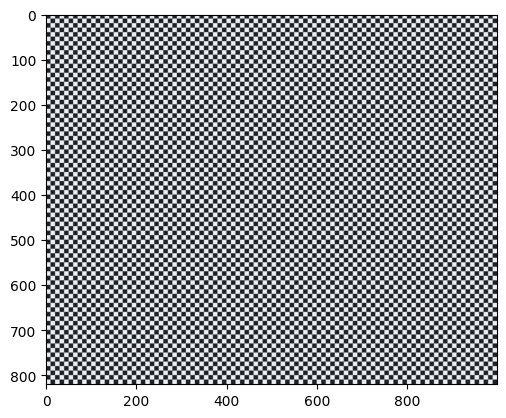

In [6]:
# Loop over all images in input folder
folder_dir = "C:/Users/Kim/Documents/Bath/Dissertation/Code/images/inputs/rooms/real"
 
for image in listdir(folder_dir):
    if image[0] >= 'a':
        filename = "images/inputs/rooms/real/" + image
        final_output_1, final_output_2 = pipeline(filename) 
        cv2.imwrite("images/outputs/final-outputs/02-02-24/" + image, final_output_1)
        # cv2.imwrite("images/outputs/final-outputs/fake/simple-" + image, final_output_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

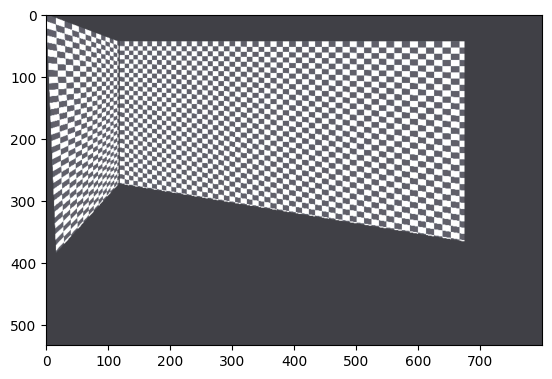

In [7]:
filename = "images/inputs/rooms/real/living-room4.png"
final_output_1, final_output_2 = pipeline(filename)
cv2.imwrite("images/outputs/final-outputs/test.png", final_output_1)
# cv2.imwrite("images/outputs/final-outputs/test-simple.png", final_output_2)